In [26]:
import sys
sys.path.append("..")

from functools import reduce

import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image

from modules import Retina
from utils import array2img, img2array

sys.path.append("..")

import torch

import model
import utils
import modules


from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler

import data_loader
from config import get_config
import torch.nn.functional as F


from torch.distributions import Normal

import torch.nn as nn




In [2]:
#load the model (code from load_checkpoint function in trainer.py):

config, unparsed = get_config()


filename = "../ckpt/ram_6_1x1_1_model_best.pth.tar"

ckpt = torch.load(filename) #model

# build RAM model
config, unparsed = get_config()

ram0 = model.RecurrentAttention(
    1,
    config.num_patches,
    config.glimpse_scale,
    1,
    config.loc_hidden,
    config.glimpse_hidden,
    config.std,
    config.hidden_size,
    10,
)

ram0.load_state_dict(ckpt["model_state"])

<All keys matched successfully>

In [3]:
torch.manual_seed(config.random_seed+1)

In [4]:
print(" Model data:\n patch size: " + str(config.patch_size) + 
    "\n num_patches: " + str(config.num_patches)+
    "\n glimpse_scale: " + str(config.glimpse_scale)+
    "\n num_channels: " + str(1)+
    "\n loc_hidden: " + str(config.loc_hidden)+
    "\n glimpse_hidden: " + str(config.glimpse_hidden)+
    "\n std: " + str(config.std)+
    "\n hidden_size: " + str(config.hidden_size)+
    "\n num_classes: " + str(10))

 Model data:
 patch size: 1
 num_patches: 1
 glimpse_scale: 1
 num_channels: 1
 loc_hidden: 128
 glimpse_hidden: 128
 std: 0.05
 hidden_size: 256
 num_classes: 10


In [5]:
ram0

RecurrentAttention(
  (sensor): GlimpseNetwork(
    (fc1): Linear(in_features=1, out_features=128, bias=True)
    (fc2): Linear(in_features=2, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=256, bias=True)
    (fc4): Linear(in_features=128, out_features=256, bias=True)
  )
  (rnn): CoreNetwork(
    (i2h): Linear(in_features=256, out_features=256, bias=True)
    (h2h): Linear(in_features=256, out_features=256, bias=True)
  )
  (locator): LocationNetwork(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (fc_lt): Linear(in_features=128, out_features=2, bias=True)
  )
  (classifier): ActionNetwork(
    (fc): Linear(in_features=256, out_features=10, bias=True)
  )
  (baseliner): BaselineNetwork(
    (fc): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [6]:
def reset():
    h_t = torch.zeros(
        1,
        config.hidden_size,
        dtype=torch.float,
        requires_grad=True,
    )
    l_t = torch.FloatTensor(
        1, 2).uniform_(-1, 1)
    l_t.requires_grad = True

    return h_t, l_t

In [7]:
reset()

(tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [8]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
trans = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.MNIST("../data", train=False, download=True, transform=trans)

In [9]:
mnistImage, label = dataset[41]
mnistImage = mnistImage.unsqueeze(1)

#do 5 glimpses
h_t, l_t = reset()

loc_list = [l_t]
for t in range(50):
    # forward pass through model
    h_t, l_t, b_t, p = ram0(mnistImage, l_t, h_t)
    loc_list.append(l_t)

# last iteration
h_t, l_t, b_t, log_probas, p = ram0(mnistImage, l_t, h_t, last=True)

pred = log_probas.data.max(1, keepdim=True)[1][0][0].item()
print("Prediction: " + str(pred) + ", actual: " + str(label))

Prediction: 0, actual: 7


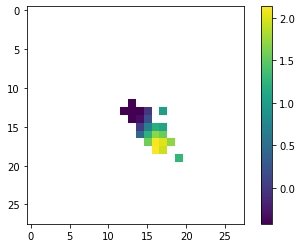

In [10]:
num_patches = config.num_patches
scale = config.glimpse_scale
patch_size = config.patch_size

glimpses = []
for loc in loc_list:
    ret = Retina(g=1, k=num_patches, s=scale)
    glimpse = ret.foveate(mnistImage, loc).data.numpy()
    glimpse = np.reshape(glimpse, [1, num_patches, 1, patch_size, patch_size])
    glimpse = np.transpose(glimpse, [0, 1, 3, 4, 2])
    glimpses.append(glimpse)

H = len(mnistImage[0][0])
showGlimpses = np.ones((H, H))*np.nan

# Update the positions with the glimpse values
for i in range(len(glimpses)):
    indices = Retina.denormalize(_, len(mnistImage[0][0]), loc_list[i])
    x, y = indices.tolist()[0]
    showGlimpses[y, x] = glimpses[i]

# Plot the image using imshow
plt.imshow(showGlimpses, cmap='viridis')
plt.colorbar()
plt.show()

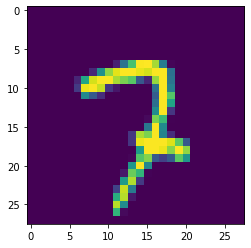

In [11]:
plt.imshow(mnistImage[0,0])

# Analyzing LocationNetwork, change it to generate a number between 0-3, corresponding to direction

In [12]:
import modules

loc_net = modules.LocationNetwork(256, 2, 0.11)
mu, l_t = loc_net(h_t)
print(mu)
print(l_t)

tensor([-4.0533], grad_fn=<SumBackward1>)
tensor([[-0.1129, -0.3319]])


In [37]:
"""
  (locator): LocationNetwork(
    (fc): Linear(in_features=256, out_features=128, bias=True)
    (fc_lt): Linear(in_features=128, out_features=2, bias=True)
  
"""

fc1= nn.Linear(256, 128)
fc_lt1 = nn.Linear(128, 1)

feat = F.relu(fc1(h_t.detach()))
mu = torch.tanh(fc_lt1(feat))
mu.shape

torch.Size([1, 1])

In [13]:
mu = torch.tensor([-0.0415,  0.1544])

l_t = torch.tensor([-0.0414,  0.1809])

"""
tensor([-0.0415,  0.1544])
tensor([-0.0414,  0.1809])
tensor(4.0126)
"""

log_pi = Normal(mu,config.std).log_prob(l_t)
print(log_pi)
print(torch.sum(log_pi))

tensor([2.0768, 1.9363])
tensor(4.0131)


In [14]:
torch.multiply(mu, 0.99)

tensor([-0.0411,  0.1529])

# Make intensity function at location

In [15]:
#testing denormalize function

"""Convert coordinates in the range [-1, 1] to
        coordinates in the range [0, T] where `T` is
        the size of the image.
        
        return (0.5 * ((coords + 1.0) * T)).long()
"""
H1 = 15
loc1 = torch.tensor([0.1, -0.09])
Retina.denormalize(_, H1, loc1)

tensor([8, 6])

In [16]:
torch.tensor(4.3).long()

tensor(4)

In [17]:
def intensity(loc, img):
    """
    loc is tensor([y, x]), 
    img is tensor with shape: (1,H,W), generally H=W
    returns intensity of 3x3 square centered about loc
    """
    totalCharge = 0
    nRows, nColumns = img.shape
    xLoc = loc[1].item()
    yLoc = loc[0].item()

    boostedImg = torch.sub(img, torch.min(img))

    for yi in range(nRows):
        for xi in range(nColumns):
            r2 = (xLoc - xi) ** 2 + (yLoc - yi) ** 2
            if (r2 != 0):
                pointCharge = boostedImg[yi, xi]/r2
                totalCharge += pointCharge

    tanhTotal = torch.tanh(totalCharge/(nRows))
    return tanhTotal.item()


0.1973753273487091


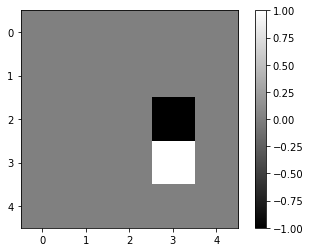

In [18]:
testImg1 = torch.zeros([5,5])
#testImg1[0,0] = 1
testImg1[3,3] = 1
#testImg1[4,3] = 1

testLoc1 = torch.tensor([2,3])
print(intensity(testLoc1, testImg1))

outImg = testImg1 + 0
outImg[testLoc1[0].item(), testLoc1[1].item()] = -1
plt.imshow(outImg, cmap="gray")
plt.colorbar()

In [19]:
testImg1[testLoc1[0]-1: testLoc1[0]+2, testLoc1[1]-1: testLoc1[1]+2]


tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 1., 0.]])

0.6197544932365417


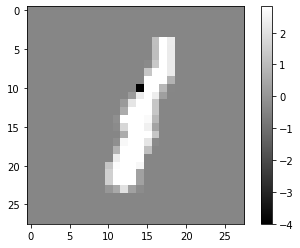

In [20]:
mnistImage, label = dataset[89]
mnistImage = mnistImage.unsqueeze(1)

#mnistImage = torch.ones_like(mnistImage)

testLoc2 = torch.tensor([10, 14])

print(intensity(testLoc2, mnistImage[0][0]))

outImg = mnistImage[0][0] + 0
outImg[testLoc2[0].item(), testLoc2[1].item()] = -4

plt.imshow(outImg, cmap="gray")
plt.colorbar()

In [21]:
torch.min(mnistImage)

tensor(-0.4242)

In [22]:
torch.max(dataset[53][0])

tensor(2.8215)

In [23]:
normalize = transforms.Normalize((0.1307,), (0.3081,))
trans = transforms.Compose([transforms.ToTensor(), normalize])

dataset = datasets.MNIST("../data", train=False, download=True, transform=trans)

index = 141
minMNIST = torch.min(dataset[index][0]).item()
maxMNIST = torch.max(dataset[index][0]).item()


print(minMNIST)
print(maxMNIST)

-0.4242129623889923
2.821486711502075


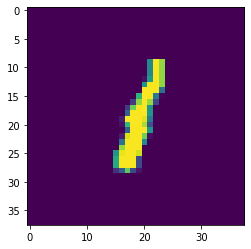

In [24]:
#mnistImage, label = dataset[89]

#mnistImage = mnistImage.unsqueeze(0)
mnistImage = F.pad(mnistImage, (5, 5, 5, 5), value=torch.min(mnistImage))
mnistImage.shape

plt.imshow(mnistImage[0,0])